# Somite Multiomics: miRNA and mRNA Peridogram Matching

We have miRNA and mRNA data from a timecourse experiment that's been performed twice, once with 12.5 minute intervals, and again with 6.25 minute intervals. The 12.5 minute miRNA was sequenced twice. So we have five data sets:

- Sub_0745_I: 6.25 min miRNA, 1st sequencing. 
- Sub_0745_II: 6.25 min miRNA, 2nd sequencing. 
- Sub_0743: 6.25 min mRNA
- Sub_0800: 12.5 min mRNA
- Sub_0814: 12.5 min miRNA

This study was motivated by examing the miRNA hsa-miR-10a-5p, which has cycling in both time courses. What is worrying is that it appears to cycle strongly every 8 time points, even though the intervals are different!

In [6]:
%load_ext autoreload
%autoreload 2
import somite_study_library as lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Text(0, 0.5, 'Normalized expression')

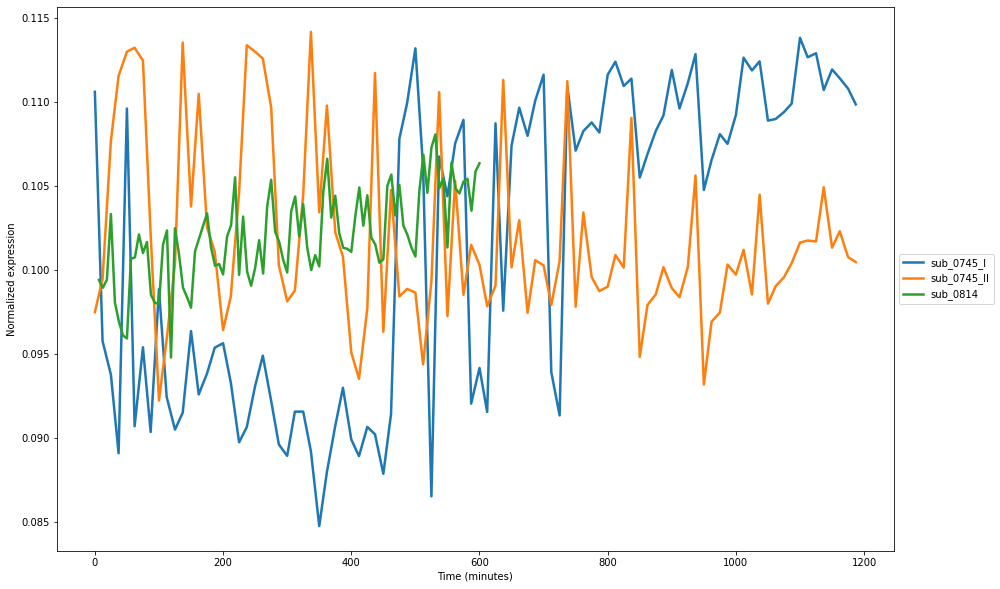

In [7]:

import somite_study_library as lib


(sub_0745_I, sub_0745_II, sub_0743, sub_0800, sub_0814) = lib.load_top_expressed_preprocessed_data()
fig = lib.plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
miRNA_of_interest = 'hsa-miR-10a-5p'
#figsize=(15,20)

for miRNA_set, label in zip((sub_0745_I, sub_0745_II, sub_0814), ('sub_0745_I','sub_0745_II', 'sub_0814')):
    position = list(miRNA_set.var.index).index(miRNA_of_interest)
    y = miRNA_set.X[:,position]
    x = miRNA_set.obs.time
    ax.plot(x,y/lib.np.linalg.norm(y), label=label, linewidth=2.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized expression')


## Study Strategy

To determine whether the cycling behavior is technical or biological, we will find miRNA-gene pairs in matching timecourses which cycle similarly. We will then take the intersection of these pairs, as we are interested in the ones common to each timecourse. To find these, we will use a different distance metric, using [periodograms](https://en.wikipedia.org/wiki/Periodogram). 

Because mRNA behavior lags behind the miRNA changes, periodograms are useful because they only measure the relative power of different frequencies, not the phase. 




In [8]:
# We are looking for mRNA genes which cycle similarly to a target miRNA. 
# Our strategy is to calculate the periodogram for the target miRNA, and all genes. 
# Sort by distance, and return n closest. 
# We'll look out 3 pairs of data. 

n_closest = 75
s800_closest_genes = lib.get_mutual_periodgram_genes(
    adata_miRNA=sub_0814, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=sub_0800,
    n_closest=n_closest
)

s743_1_closest_genes = lib.get_mutual_periodgram_genes(
    adata_miRNA=sub_0745_I, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=sub_0743,
    n_closest=n_closest
)

s743_2_closest_genes = lib.get_mutual_periodgram_genes(
    adata_miRNA=sub_0745_II, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=sub_0743,
    n_closest=n_closest
)

common_genes = (
    set(s800_closest_genes.index) 
    & set(s743_1_closest_genes.index)
    & set(s743_2_closest_genes.index)
)

print(f'The Common Genes are: {", ".join(common_genes)}')


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


The Common Genes are: RBMX, NPM1, TUBA1A, RPL13A


We are not sure about the significance of this finding. We visited [miRDB](http://mirdb.org/), an online database for miRNA target prediction, which lists RPL13A as a target, but not the other three. 

## Background and Future Work

### K-means clustering in periodogram space.

One concern we have is how noisy the data is, as well as the possible 8 cycle sequencing artifact. So we would like to survey more miRNA species. One way to do this is to cluster the top expressed miRNA into groups, and see if they all share the same artifact.

In [9]:
K = 6
s814_pd_array = lib.get_periodgram(sub_0814)
#print(s814_pd_array.sh)
C, centroids = lib.k_means_from_pd_data(s814_pd_array,K=K)

print('C = \n', C)

converged on iter: 2
C = 
 [3 2 0 0 0 0 2 2 4 2 4 0 0 3 3 4 3 2 5 0 3 2 2 3 3 0 0 3 4 2 2 5 4 2 0 0 3
 2 4 1 0 0 1 0 3 5 0 0 3 3]


In [15]:
#print(sub_0814.obs.time)

NameError: name 'gene_I_set' is not defined

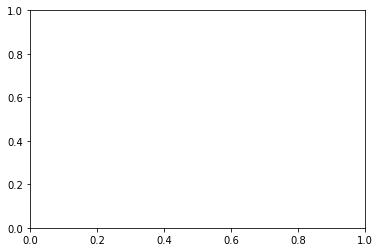

In [16]:

fig = lib.plt.figure()
ax = fig.add_subplot(111)
time = sub_0814.obs.time

for g in gene_I_set:
    position = list(sub_0814.var.index).index(g)
    y = sub_0814.X[:,position]
    ax.plot(time,y/np.linalg.norm(y), label=sub_0814.var.index[position].split(',')[0])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

position1 = list(sub_0814.var.index).index('hsa-miR-10a-5p')
ax.plot(time,y/np.linalg.norm(y), label=sub_0814.var.index[position1].split(',')[0])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

   

In [ ]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


In [ ]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s800_top.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [ ]:
print(s814_clodis_gene)

In [ ]:
K = 6
C, centroids = k_means_from_pd_data(s745_pd_array_first_run,K)

print('C = \n', C)


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s745_pd_first_run[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )